# Análise de Correlação do Classificador e Cálculo coerência do conjunto de dados FAQUAD.

Realiza a análise de correlação entre as classificações realizadas e o cálculo de medida de coerência utilizando BERT no FAQUAD.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicioProcessamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documentoLimpo = re.compile("<.*?>")
    return re.sub(documentoLimpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nomeArquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nomeArquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nomeArquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nomeArquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nomeArquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nomeArquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Calcula a média de uma lista tempo string no formato hh:mm:ss.

In [ ]:
# Import das bibliotecas.
from cmath import rect, phase
from math import radians, degrees
  
def mediaAngulo(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))
 
def mediaTempo(tempos):
    '''
    Calcula a média de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Verifica se deu algum dia
    dia = 24 * 60 * 60
    # Converte para angulos
    paraAngulos = [s * 360. / dia for s in segundos]
    # Calcula a média dos angulos
    mediaComoAngulo = mediaAngulo(paraAngulos)
    media_segundos = mediaComoAngulo * dia / 360.
    if media_segundos < 0:
        media_segundos += dia
    # Recupera as horas e os minutos  
    h, m = divmod(media_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)    
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Calcula a soma de uma lista de tempo string no formato hh:mm:ss

In [ ]:
def somaTempo(tempos):
    '''
    Calcula a soma de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Soma os segundos
    soma_segundos = sum([s * 1. for s in segundos])
    # Recupera as horas e os minutos   
    h, m = divmod(soma_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)    
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )
    numero_documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [ ]:
# Se estiver executando no Google Colaboratory.
import sys

# Retorna true ou false se estiver no Google Colaboratory.
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

2022-03-18 12:45:09,822 : INFO : NumExpr defaulting to 2 threads.
2022-03-18 12:45:10,323 : INFO : Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

2022-03-18 12:45:16,267 : INFO : Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

2022-03-18 12:45:16,300 : INFO : Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

2022-03-18 12:45:16,304 : INFO : Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
2022-03-18 12:45:16,308 : INFO : e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Mounted at /content/drive


# 2 Parametrização

## Gerais

In [ ]:
# Nome base das saidas do projeto
NOMEBASESAIDA = "MedidaCoerenciaFaquad_v1"

# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
NUMERO_DOCUMENTOS_PERTURBADOS = 20

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 20

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    do_lower_case = False,  # default True
    output_attentions = False,  # default False
    output_hidden_states = True, # default False
    use_wandb = True,    
    salvar_medicao = True, #Salva o resultado da medição
    salvar_avaliacao = True, # Salva o resultado da avaliação das medições
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    numero_documentos_perturbados = NUMERO_DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara. 
    estrategia_medida = 0, # Atributo usado para os logs do wandb. 0 - MEAN estratégia média / 1 - MAX  estratégia maior
    filtro_palavra = 0 # Atributo usado para os logs do wandb. 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "FAQUAD"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Classificador Binário usando o Método Kfold

In [ ]:
# Nome base das saidas do projeto C = Cris, SB = SmartBatch, KF = KFold
NOMEBASESAIDA = "AjusteFinoFaquad_C_SB_KF_v1"

## 3.1 Carrega o resultado e parâmetros da melhor classificação

### 3.1.1 Função que encontra a melhor classificação

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosClassificacaoKFold(DIRETORIO_COHEBERT, 
                                         _DOCUMENTOS_PERTURBADOS, 
                                         _TOP_K_PREDICAO):
  
  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau','_BERTmultilingual']
  MODELO_BERT = ['_BERTimbau']

  #TAMANHO_BERT = ['_base','_large']
  TAMANHO_BERT = ['_large']
  
  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = [1, 2, 3, 4, 5]

  # Tamanho dos lotes
  TAMANHO_LOTE = [16, 32]

  # Salva resultados intermediários
  EPOCA = [2, 3, 4]

  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"  

  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_TAXAS_DE_APRENDIZAGEM = 0
  MELHOR_TAMANHO_LOTE = 0
  MELHOR_EPOCA_EXECUCA = 0
  MELHOR_ACURACIA = 0
  MELHOR_TEMPO = 0

  lista_resultados = []

  listaTempoTotal = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    for modelo in MODELO_BERT:    
      for tamanho in TAMANHO_BERT:
        if modelo != '_BERTmultilingual' or tamanho != '_large':                  
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO:              
              DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"              
              # Verifica se o diretório dos resultados existe.
              if os.path.exists(DIRETORIO_AVALIACAO_PK):
                arquivos = os.listdir(DIRETORIO_AVALIACAO_PK) 
                contaRegR = 0
                for lote in TAMANHO_LOTE:
                  for taxaaprendizagem in TAXAS_DE_APRENDIZAGEM:                      
                    for epoca in EPOCA:  
                        # Acumuladores.
                        somaAcuracia = 0
                        listaTempo = []
                        contaFolds = 0 
                        contaReg = 0
                        
                        for i in range(len(arquivos)):
                          for fold in range(1,11):
                            # Filtra o nome do arquivo a ser avaliado                                                     
                            if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                                  and (("_K_" + str(top_k_predicao)+"_") in arquivos[i]) 
                                  and (("_b_" + str(lote)) in arquivos[i]) 
                                  and (modelo in arquivos[i]) 
                                  and (tamanho in arquivos[i]) 
                                  and (('_f' + str(fold) + '_') in arquivos[i]) 
                                  and (("e_" + str(epoca)) in arquivos[i]) 
                                  and (("lr_" + str(taxaaprendizagem)) in arquivos[i])):                           

                                NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO_PK + arquivos[i]                              
                                # Verifica se o arquivo existe.
                                if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                                  # Carrega os dados do arquivo  
                                  dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                      
                                  # Conta o número de folds.
                                  contaFolds = contaFolds + 1
                                  
                                  # Mostra os dados do teste do fold.
                                  for index, linha in dados.iterrows():        
                                    # Cálculo das estatísticas
                                    acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])                         
                                    #print('{};{};{};{:.8f};{}'.format(fold, index, arquivos[i],acc,linha['tempo']))
                                    # Guarda o tempo.
                                    listaTempo.append(str(linha['tempo']))
                                    # Conta o número de registros.
                                    contaReg = contaReg + 1
                                    
                                  # Realiza a soma da acurácia do arquivo.
                                  somaAcuracia = somaAcuracia + dados['acuracia'].sum()
                                        
                        if contaFolds != 0:
                          # Calcula a média.                          
                          mediaAcuracia = somaAcuracia/contaReg

                          # Guarda os resultados de todos os folds  
                          lista_resultados.append([documentos_perturbados,top_k_predicao,taxaaprendizagem,lote,epoca, mediaAcuracia, somaTempo(listaTempo)])
                          
                          if mediaAcuracia > MELHOR_ACURACIA:
                              MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                              MELHOR_TOP_K_PREDICAO = top_k_predicao
                              MELHOR_TAXAS_DE_APRENDIZAGEM = taxaaprendizagem
                              MELHOR_TAMANHO_LOTE = lote
                              MELHOR_EPOCA_EXECUCAO = epoca
                              MELHOR_ACURACIA = mediaAcuracia
                              MELHOR_TEMPO = somaTempo(listaTempo)
                       
                        else:                          
                            print('Nenhum arquivo de avaliação encontrado')
                
              else:
                print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')                        
    
    # Retorno do melhor valor
    lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[5], reverse=True)
    return MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultado_ordenado
  else:
    print('Diretório com os resultados não encontrado')

Recupera os melhores resultados

In [ ]:
DOCUMENTOS_PERTURBADOS = [1, 20]
TOP_K_PREDICAO = [1, 10, 100, 1000]

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultados = getResultadosClassificacaoKFold(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [ ]:
print("Parâmetros da melhor acurácia do classificador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Taxa de aprendizagem  :", MELHOR_TAXAS_DE_APRENDIZAGEM, 
      "\n  Lote                  :", MELHOR_TAMANHO_LOTE, 
      "\n  Epoca execução        :", MELHOR_EPOCA_EXECUCAO, 
      "\n  Acurácia              :", MELHOR_ACURACIA, 
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista das acurácias ranqueadas")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros da melhor acurácia do classificador

  Documentos Perturbados: 20 
  Top k predição        : 1000 
  Taxa de aprendizagem  : 1 
  Lote                  : 16 
  Epoca execução        : 4 
  Acurácia              : 0.9880000000000001 
  Tempo execução        : 04:30:09

Lista das acurácias ranqueadas
1 = [20, 1000, 1, 16, 4, 0.9880000000000001, '04:30:09']
2 = [20, 1000, 1, 32, 4, 0.9872222222222222, '03:13:19']
3 = [20, 1000, 1, 16, 3, 0.9854722222222222, '03:21:10']
4 = [20, 1000, 1, 16, 2, 0.9853888888888889, '02:12:39']
5 = [20, 1000, 1, 32, 3, 0.9844166666666666, '02:21:55']
6 = [20, 1000, 2, 32, 4, 0.9827499999999999, '03:14:09']
7 = [20, 100, 1, 16, 4, 0.9825555555555556, '05:09:49']
8 = [20, 1000, 2, 16, 3, 0.9803333333333333, '03:31:40']
9 = [20, 1000, 2, 16, 4, 0.9800833333333333, '04:44:18']
10 = [20, 1, 1, 16, 4, 0.9798611111111111, '05:10:13']
11 = [20, 1000, 1, 32, 2, 0.979638888888889, '01:32:44']
12 = [20, 1000, 2, 32, 3, 0.9793333333333333, '02:22:42']
13 = [2

### Escolhendo um resultado diferente do melhor

In [ ]:
#MELHOR_DOCUMENTOS_PERTURBADOS = 20
#MELHOR_TOP_K_PREDICAO = 100
#MELHOR_TAXAS_DE_APRENDIZAGEM = 1
#MELHOR_TAMANHO_LOTE = 16
#MELHOR_EPOCA_EXECUCAO = 4
#MELHOR_ACURACIA = 0.9825555555555556
#MELHOR_TEMPO = '05:09:49'
#lista_resultados= []

### 3.1.2 Função que carrega e calcula a média da acurácia dos folds


In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def relatorioResultados(DIRETORIO_COHEBERT, 
                        TEXTO_PURO, 
                        _DOCUMENTOS_PERTURBADOS, 
                        _TOP_K_PREDICAO,
                        _TAXAS_DE_APRENDIZAGEM,
                        _TAMANHO_LOTE,
                        _EPOCA_EXECUCAO
                        ):
  
  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau','_BERTmultilingual']
  MODELO_BERT = ['_BERTimbau']

  #TAMANHO_BERT = ['_base','_large']
  TAMANHO_BERT = ['_large']

  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = _TAXAS_DE_APRENDIZAGEM

  # Tamanho dos lotes
  TAMANHO_LOTE = _TAMANHO_LOTE

  # Salva resultados intermediários
  EPOCA = _EPOCA_EXECUCAO
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"  

  listaTempoTotal = []  
  totalGeralFolds = 0
  totalGeralRegistros = 0
  totalArquivos = (len(MODELO_BERT) * len(TAMANHO_BERT) *
                   len(DOCUMENTOS_PERTURBADOS) *  len(TOP_K_PREDICAO) * 
                   len(TAMANHO_LOTE) * len(EPOCA) * len(TAXAS_DE_APRENDIZAGEM) * KFOLDS)
  #totalArquivos = 400  
  if TEXTO_PURO == False:
    print("totalArquivos =", totalArquivos) 

  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    for modelo in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo != '_BERTmultilingual' or tamanho != '_large':  
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO:        
              DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"
        
              # Verifica se o diretório dos resultados existe.
              if os.path.exists(DIRETORIO_AVALIACAO_PK):
                arquivos = os.listdir(DIRETORIO_AVALIACAO_PK) 
                for lote in TAMANHO_LOTE:
                  for taxaaprendizagem in TAXAS_DE_APRENDIZAGEM:
                    for epoca in EPOCA:                    
                        # Acumuladores.
                        somaAcuracia = 0
                        listaTempo = []
                        contaFolds = 0 
                        contaReg = 0
                        if TEXTO_PURO == False:
                           print("\nModelo:", modelo, " Tamanho:", tamanho, " N Doc:",documentos_perturbados,
                                 " Top k:", top_k_predicao, " Lote:", lote, " Taxa Apred.:", taxaaprendizagem, " Época:", epoca)
       
                        for i in range(len(arquivos)):                                    
                          for fold in range(1,11):                                                         
                            if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                                and (("_K_" + str(top_k_predicao)+"_") in arquivos[i]) 
                                and (("_b_" + str(lote)) in arquivos[i]) 
                                and (modelo in arquivos[i]) 
                                and (tamanho in arquivos[i]) 
                                and (("_b_" + str(lote)) in arquivos[i]) 
                                and (('_f' + str(fold) + '_') in arquivos[i]) 
                                and (("e_" + str(epoca)) in arquivos[i]) 
                                and (("lr_" + str(taxaaprendizagem)) in arquivos[i])):
                             
                                NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO_PK + arquivos[i]                              
                                # Verifica se o arquivo existe.
                                if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                                  # Carrega os dados do arquivo  
                                  dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                      
                                  # Conta o número de folds.
                                  contaFolds = contaFolds + 1
                                  # Conta o número geral de folds
                                  totalGeralFolds = totalGeralFolds + 1

                                  # Mostra os dados do teste do fold.
                                  for index, linha in dados.iterrows():        
                                    # Cálculo das estatísticas
                                    acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])                         
                                    print('{};{};{};{};{}'.format(fold, index, arquivos[i],str(acc).replace(".", ","),linha['tempo']))
                                    #print('{};{};{};{:.8f};{}'.format(fold, index, arquivos[i],acc,linha['tempo']))
                                    # Guarda o tempo.
                                    listaTempo.append(str(linha['tempo']))

                                    # Conta o número de registros.
                                    contaReg = contaReg + 1
                                    # Conta o número geral de registros.
                                    totalGeralRegistros = totalGeralRegistros + 1

                                  # Realiza a soma da acurácia do arquivo.
                                  somaAcuracia = somaAcuracia + dados['acuracia'].sum()

                        
                        if contaFolds != 0:
                            # Mostra a soma da acurácia . 
                            if TEXTO_PURO == False:
                              print('Total acurácia                                           : {:.8f}'.format(somaAcuracia))
                            # Mostra a quantidade de folds.
                            if TEXTO_PURO == False:
                              print('Quantidade de folds                                      : {}'.format(contaFolds))  
                            # Mostra a quantidade de registros.
                            if TEXTO_PURO == False:
                              print('Quantidade de registros                                  : {}'.format(contaReg))  
                            # Calcula a média.
                            if TEXTO_PURO == False:
                              mediaAcuracia = somaAcuracia/contaReg
                              print('A média da acurácia de {:2d} registros é                    : {:.8f}'.format(contaReg, mediaAcuracia))
                              print('O tempo gasto na execução do treinamento {:2d} registros é  : {}'.format(contaReg, somaTempo(listaTempo)))
                              print('A média de tempo de execução de {:2d} registros é           : {}\n'.format(contaReg, mediaTempo(listaTempo)))
                            
                            if epoca == 4:
                              # Guarda o tempo total
                              listaTempoTotal.append(somaTempo(listaTempo))
                        else:
                            if TEXTO_PURO == False:
                              print('Nenhum arquivo de avaliação encontrado')
                                    
              else:
                print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')                        
    
  else:
      print('Diretório com os resultados não encontrado')        

Recupera os dados dos melhores resultados

In [ ]:
# Diretório do cohebert
DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
TAXAS_DE_APRENDIZAGEM = [MELHOR_TAXAS_DE_APRENDIZAGEM]
TAMANHO_LOTE = [MELHOR_TAMANHO_LOTE]
EPOCA_EXECUCAO = [MELHOR_EPOCA_EXECUCAO]
TEXTO_PURO = False

relatorioResultados(DIRETORIO_COHEBERT, 
                    TEXTO_PURO, 
                    DOCUMENTOS_PERTURBADOS, 
                    TOP_K_PREDICAO, 
                    TAXAS_DE_APRENDIZAGEM, 
                    TAMANHO_LOTE, 
                    EPOCA_EXECUCAO)

totalArquivos = 10

Modelo: _BERTimbau  Tamanho: _large  N Doc: 20  Top k: 1000  Lote: 16  Taxa Apred.: 1  Época: 4
1;0;AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f1_BERTimbau_large.csv;0,9808333333333333;0:26:16
2;0;AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f2_BERTimbau_large.csv;0,9880555555555556;0:26:18
3;0;AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f3_BERTimbau_large.csv;0,9891666666666666;0:26:27
4;0;AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f4_BERTimbau_large.csv;0,9866666666666667;0:26:36
5;0;AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f5_BERTimbau_large.csv;0,9877777777777778;0:26:52
6;0;AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f6_BERTimbau_large.csv;0,9911111111111112;0:27:12
7;0;AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f7_BERTimbau_large.csv;0,9872222222222222;0:27:24
8;0;AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f8_BERTimbau_l

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOMEARQUIVOORIGINAL = "original.csv"
NOMEARQUIVOORIGINALCOMPACTADO = "original.zip"
NOMEARQUIVOORIGINALPOS = "originalpos.csv"
NOMEARQUIVOORIGINALPOSCOMPACTADO = "originalpos.zip"

NOMEARQUIVOPERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOMEARQUIVOPERTURBADOCOMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOMEARQUIVOPERTURBADOPOS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOMEARQUIVOPERTURBADOPOSCOMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-03-18 12:46:57,434 : INFO : Diretório criado: /content/FAQUAD


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOMEARQUIVOORIGINALCOMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOMEARQUIVOORIGINALPOSCOMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOMEARQUIVOPERTURBADOCOMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOMEARQUIVOPERTURBADOPOSCOMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-03-18 12:46:59,579 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOMEARQUIVOORIGINALCOMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOMEARQUIVOORIGINALPOSCOMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOMEARQUIVOPERTURBADOCOMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOMEARQUIVOPERTURBADOPOSCOMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-03-18 12:47:00,115 : INFO : Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOMEARQUIVOORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOMEARQUIVOORIGINALPOS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-03-18 12:47:00,161 : INFO : TERMINADO ORIGINAIS: 900.
2022-03-18 12:47:00,163 : INFO : TERMINADO ORIGINAIS POS: 900.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
287,ab221182bdf242d98e9b5f6bb9a34a52,['Qual termo é controverso nas ciências em ger...,Qual termo é controverso nas ciências em geral?
442,f1146e1e59e648a8b095e7d6d7e39f7f,['O que acontece caso o aluno se ausente da re...,O que acontece caso o aluno se ausente da reno...
525,a9814c246dee46b59b733c3a473b595e,['O que a máquina de turing utilizava para ope...,O que a máquina de turing utilizava para opera...
109,95cea743eb4c4328958d41f7e445d950,['Em que a maioria dos cientistas da computaçã...,Em que a maioria dos cientistas da computação ...
251,7e00d87ee5c5462686e4c5ce506a673f,['Qual era o objetivo do curso de engenharia d...,Qual era o objetivo do curso de engenharia de ...


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
843,84b0eef8870841c5bf638cd3e54b0284,"[[['quem', 'dá', 'a', 'nota', 'final', 'ao', '..."
718,f71500e2feec42198524d833bc76cd14,"[[['O', 'que', 'o', 'desenvolvimento', 'cada',..."
441,ba930d3c69b445fe95787bee95481a69,"[[['O', 'que', 'acontece', 'caso', 'o', 'acadê..."
604,73fc0c9b75344150be634b3d1d31dd1f,"[[['Quem', 'deve', 'corrigir', 'e', 'previnir'..."
423,859b15a179714620906bf10f0b284e95,"[[['Qual', 'a', 'condição', 'para', 'matrícula..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-03-18 12:47:00,304 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 900.
2022-03-18 12:47:00,306 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 900.


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOMEARQUIVOPERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOMEARQUIVOPERTURBADOPOS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-03-18 12:47:00,523 : INFO : TERMINADO PERTURBADOS: 18000.
2022-03-18 12:47:00,525 : INFO : TERMINADO PERTURBADOS POS: 18000.


In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documentoPerturbado,sentencas
3676,536fd8c1b1a943ecb74a79aa72ff8a48_pert_16,['Por que o Z1 foi permitido pelo governo alem...,Por que o Z1 foi permitido pelo governo alemão ?,[['Por que o Z1 foi [MASK] pelo governo alemão...
15308,3b95690d7e9b4074b87c2c1476e2ec0b_pert_8,['O que é Tecnologia da Lar ?'],O que é Tecnologia da Lar ?,"[['O que é Tecnologia da [MASK] ?', 'Informaçã..."
14373,f71500e2feec42198524d833bc76cd14_pert_13,['O que o desenvolvimento cada vez mais rápido...,O que o desenvolvimento cada vez mais rápido d...,[['O que o desenvolvimento cada vez mais rápid...
10547,29f13da0db884441a2e7dc9e34f62d4d_pert_7,['Qual era o número de cadeira acadêmicos no B...,Qual era o número de cadeira acadêmicos no Bra...,[['Qual era o número de [MASK] acadêmicos no B...
16349,69ac001c690c4a02a2151758743f6db3_pert_9,['Como ficou Praga a primeira universidade mod...,Como ficou Praga a primeira universidade moder...,[['Como ficou [MASK] a primeira universidade m...


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
4841,9345e1a73aee4ea191ff28df49a56c5b_pert_1,"[[['Quando', 'os', 'primeiros', 'docentes', 'd..."
13067,51b282c3346b461c8006f338ed5c0bd6_pert_7,"[[['Qual', 'o', 'número', 'mínimo', 'de', 'cré..."
2715,992c12a7782a470ea48a1438c5ae7a0e_pert_15,"[[['Quantos', 'números', 'um', 'byte', 'possa'..."
5282,b5874b7d124c42b284e1c0799ec8efe4_pert_2,"[[['Qual', 'um', 'exemplo', 'recente', 'de', '..."
11100,f2ccd205ac284d239c3da37353f84196_pert_0,"[[['Os', 'modelos', '2006', 'são', 'equivalent..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-03-18 12:47:02,533 : INFO : TERMINADO CORREÇÃO PERTURBADO: 18000.
2022-03-18 12:47:02,534 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 18000.


### 3.2.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

lista_documentos_agrupados = []

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
    #print("linha_documento:",linha_documento)
    # Recupera o id do documento
    id_documento = linha_documento[0]     
    #print("id_documento:",id_documento)     
 
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento[1]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
    lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
  
    # Percorre os documentos perturbados apartir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(id_documento) + "_pert_" + str(j)

      # localiza o documento perturbado 
      documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
      # Recupera a sentença do documento perturbado
      lista_perturbado = documento_perturbado[1]
          
      # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
      lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[2], 0])    

logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

Processando 900 documentos originais


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

2022-03-18 12:47:31,430 : INFO : TERMINADO AGRUPAMENTO: 18900.


Converte em um dataframe

In [ ]:
# Cria o dataframe da lista
dflista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

dflista_documentos_agrupados = dflista_documentos_agrupados.astype(tipos)

In [ ]:
dflista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
10857,f20ebd2a1baa435e8458af51f6397bea,[Quem listou os maiores desafios no campo da m...,Quem listou os maiores desafios no campo da ma...,1
11046,7a50b2ccd7b9424f87bf312e60fc9a44,[Qual modelo computacional propôs a construção...,Qual modelo computacional propôs a construção ...,1
12681,2f91caf3322742e190beae0fd37262d3_pert_17,[Qual deve ser a frequência do acadêmico para ...,Qual deve ser a frequência do acadêmico para q...,0
800,ecefc6cb3cc44bef8c606567e8ae756b_pert_1,[O que é necessário publicar para comprovar a ...,O que é necessário publicar para comprovar a p...,0
9182,4ac2a64c1af245c5b712fd7078d25628_pert_4,[O que o discente envia fazer na seleção de di...,O que o discente envia fazer na seleção de dis...,0


In [ ]:
# Importa das bibliotecas
import pandas as pd

# Concatena as listas de documentos originais e perturbados
dflista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(dflista_documentos_agrupados_pos)))

2022-03-18 12:47:31,503 : INFO : TERMINADO AGRUPAMENTO POS: 18900.


In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

dflista_documentos_agrupados_pos = dflista_documentos_agrupados_pos.astype(tipos)

In [ ]:
dflista_documentos_agrupados_pos.sample(5)

,id,pos_documento
167,5c91b3d0d6f54872b84b68e61cca84ca,"[[[Quem, construiu, a, primeira, máquina, de, ..."
8048,8392f85c85024a878d983f7692fa98ab_pert_8,"[[[O, que, era, dizer, Total, de, Alunos, Equi..."
17475,39fd8cfbb7e54ca280c4fc09bdc91a1a_pert_15,"[[[como, falou, a, componente, curricular, não..."
2940,6d29de5b8a674d7685457daba539eb0b_pert_0,"[[[Onde, geralmente, pegou, a, próxima, instru..."
12348,c308a5365bea44458a70619f4b131df0_pert_8,"[[[O, que, _, ser, respeitado, na, inscrição, ..."


## 3.3 Carrega os dados da classificação

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getDadosClassificacaoCompactado(DIRETORIO_COHEBERT,                           
                          _DOCUMENTOS_PERTURBADOS, 
                          _TOP_K_PREDICAO,
                          _EPOCA,
                          _TAXAS_DE_APRENDIZAGEM,
                          _TAMANHO_LOTE,
                          _EPOCA_EXECUCAO,
                          _MODELO_BERT = '_BERTimbau',
                          _TAMANHO_BERT = '_large'
                          ):

  # Diretório para carregar o arquivo.
  DIRETORIO_CLASSIFICACAO_DRIVE = DIRETORIO_DRIVE + "validacao_classificacao_palavra/kfold/Classificacao/" + "P_" + str(_DOCUMENTOS_PERTURBADOS) + "_K_" + str(_TOP_K_PREDICAO) + "/"

  # Diretório local para carregar o arquivo
  DIRETORIO_CLASSIFICACAO_LOCAL = DIRETORIO_LOCAL + "Classificacao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_CLASSIFICACAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_CLASSIFICACAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_CLASSIFICACAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_CLASSIFICACAO_LOCAL))
    
  # Dataframe que será retornado após o preenchimento
  df_dados_classificacao = pd.DataFrame()

  # Verifica se o diretório das classificações existem.
  if os.path.exists(DIRETORIO_CLASSIFICACAO_DRIVE):
    
    # Carrega o nome dos arquivos do drive
    arquivos = os.listdir(DIRETORIO_CLASSIFICACAO_DRIVE)     

    print('\nModelo:', _MODELO_BERT, 
          ' Tamanho:', _TAMANHO_BERT, 
          ' Np:', str(_DOCUMENTOS_PERTURBADOS), 
          ' Topk:', str(_TOP_K_PREDICAO), 
          ' Lote:', str(_TAMANHO_LOTE), 
          ' Taxa Apr.: ', str(_TAXAS_DE_APRENDIZAGEM),
          ' Epoca:', str(_EPOCA_EXECUCAO))
    
    # Acumuladores.
    conta_folds = 0 
    conta_reg = 0

    # Percorre os folds 
    for fold in range(1,11): 
      # Nome do arquivo
      NOME_ARQUIVO_CLASSIFICACAO = (NOME_BASE_SAIDA + "_P_" +  str(_DOCUMENTOS_PERTURBADOS) 
                                  + "_K_" + str(_TOP_K_PREDICAO) 
                                  + "_E_" + str(_EPOCA) 
                                  + "_e_" + str(_EPOCA_EXECUCAO) 
                                  + "_lr_" + str(_TAXAS_DE_APRENDIZAGEM) 
                                  + "_b_" +  str(_TAMANHO_LOTE)  
                                  + "_" +  str(_TAMANHO_LOTE)  
                                  + "_f" + str(fold) 
                                  + _MODELO_BERT 
                                  + _TAMANHO_BERT)
      
      # Caminho completo do arquivo compactado no drive
      NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO = DIRETORIO_CLASSIFICACAO_DRIVE + NOME_ARQUIVO_CLASSIFICACAO + ".zip"
      # print("NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO)

      # Caminho completo do arquivo compactado no local
      NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO = DIRETORIO_CLASSIFICACAO_LOCAL + NOME_ARQUIVO_CLASSIFICACAO + ".zip"
      # print("NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO)

      # Caminho completo do arquivo no local
      NOME_ARQUIVO_CLASSIFICACAO_LOCAL = DIRETORIO_CLASSIFICACAO_LOCAL + NOME_ARQUIVO_CLASSIFICACAO + ".csv"
      # print("NOME_ARQUIVO_CLASSIFICACAO_LOCAL:", NOME_ARQUIVO_CLASSIFICACAO_LOCAL)

      # Verifica se o arquivo existe.
      if os.path.isfile(NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO):

          # Copia arquivo da classificação compactado do google drive para o drive local
          !cp "$NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO"  
                        
          # Descompacta arquivo da classificação compactado no drive local
          !unzip -o -j -q "$NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO" -d "$DIRETORIO_CLASSIFICACAO_LOCAL"

          # Carrega os dados do arquivo  
          dados = pd.read_csv(NOME_ARQUIVO_CLASSIFICACAO_LOCAL, sep=';')
          
          # Concatena com os dados lidos anteriormente
          df_dados_classificacao = pd.concat([df_dados_classificacao, dados], ignore_index=True)
            
          # Conta o número de folds.
          conta_folds = conta_folds + 1

          conta_reg = conta_reg + len(dados)
      else:
          print('Arquivo não encontrado')
              
    print('Folds:', conta_folds, ' Regs:', conta_reg)
  else:
      print('Diretório com os resultados não encontrado')

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  df_dados_classificacao = df_dados_classificacao.astype(tipos)      

  print('Registros:', len(df_dados_classificacao))   

  return df_dados_classificacao 

In [ ]:
DOCUMENTOS_PERTURBADOS = MELHOR_DOCUMENTOS_PERTURBADOS
TOP_K_PREDICAO = MELHOR_TOP_K_PREDICAO
EPOCA = 4
TAXAS_DE_APRENDIZAGEM = MELHOR_TAXAS_DE_APRENDIZAGEM
TAMANHO_LOTE = MELHOR_TAMANHO_LOTE
EPOCA_EXECUCAO = MELHOR_EPOCA_EXECUCAO

# Recupera os dados da melhor classificação
dfDadosClassificacao = getDadosClassificacaoCompactado(DIRETORIO_COHEBERT, 
                                             DOCUMENTOS_PERTURBADOS, 
                                             TOP_K_PREDICAO,
                                             EPOCA,
                                             TAXAS_DE_APRENDIZAGEM,
                                             TAMANHO_LOTE,
                                             EPOCA_EXECUCAO)


Modelo: _BERTimbau  Tamanho: _large  Np: 20  Topk: 1000  Lote: 16  Taxa Apr.:  1  Epoca: 4
/content/drive/MyDrive/Colab Notebooks/Data/FAQUAD/validacao_classificacao_palavra/kfold/Classificacao/P_20_K_1000/AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f1_BERTimbau_large.csv
/content/drive/MyDrive/Colab Notebooks/Data/FAQUAD/validacao_classificacao_palavra/kfold/Classificacao/P_20_K_1000/AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f2_BERTimbau_large.csv
/content/drive/MyDrive/Colab Notebooks/Data/FAQUAD/validacao_classificacao_palavra/kfold/Classificacao/P_20_K_1000/AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f3_BERTimbau_large.csv
/content/drive/MyDrive/Colab Notebooks/Data/FAQUAD/validacao_classificacao_palavra/kfold/Classificacao/P_20_K_1000/AjusteFinoFaquad_v1_C_SB_KF_P_20_K_1000_E_4_e_4_lr_1_b_16_16_f4_BERTimbau_large.csv
/content/drive/MyDrive/Colab Notebooks/Data/FAQUAD/validacao_classificacao_palavra/kfold/Classificacao/P_20_K_10

In [ ]:
dfDadosClassificacao.sample(5)

,data,id,classe,predicao
17711,01/03/2022 13:24,fb1dd28864324e9a9d6d657f7bb6a5f9,1,1
32115,01/03/2022 15:20,f1866ef29f9a4b2bb069b897168cc3ea,1,1
30508,01/03/2022 15:20,0b70044075784d24ae6743c4ebb9c0e9,1,1
22925,01/03/2022 14:22,445387abf59e43cbbf3b58f7a224c6c0,1,0
54,01/03/2022 11:32,5d670b9c1fa442129c2c4cd6348c4392_pert_11,0,1


## 3.4 Analisa os dados das classificações

### Acurácia

In [ ]:
def calculoClassificacao(dfDadosClassificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in dfDadosClassificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1        
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1        
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1        

  # Acurácia indica uma performance geral do modelo. 
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0
    
  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0
  
  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0  

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:  
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [ ]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(dfDadosClassificacao)

#dflistaParesDocumentosClassificados

print('Acurácia:', acc)
print('Recall  :', rec)
print('Precisão:', pre)
print('F1      :', f1)
print('vp      :', vp_s)
print('vn      :', vn_s)
print('fp      :', fp_s)
print('fn      :', fn_s)
total = vp_s + vn_s + fp_s + fn_s
print('Total   :', total)

Acurácia: 0.988
Recall  : 0.9857869704678686
Precisão: 0.9902777777777778
F1      : 0.9880272712155646
vp      : 17825
vn      : 17743
fp      : 175
fn      : 257
Total   : 36000


#### Matriz de confusão

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18000
           1       0.99      0.99      0.99     18000

    accuracy                           0.99     36000
   macro avg       0.99      0.99      0.99     36000
weighted avg       0.99      0.99      0.99     36000



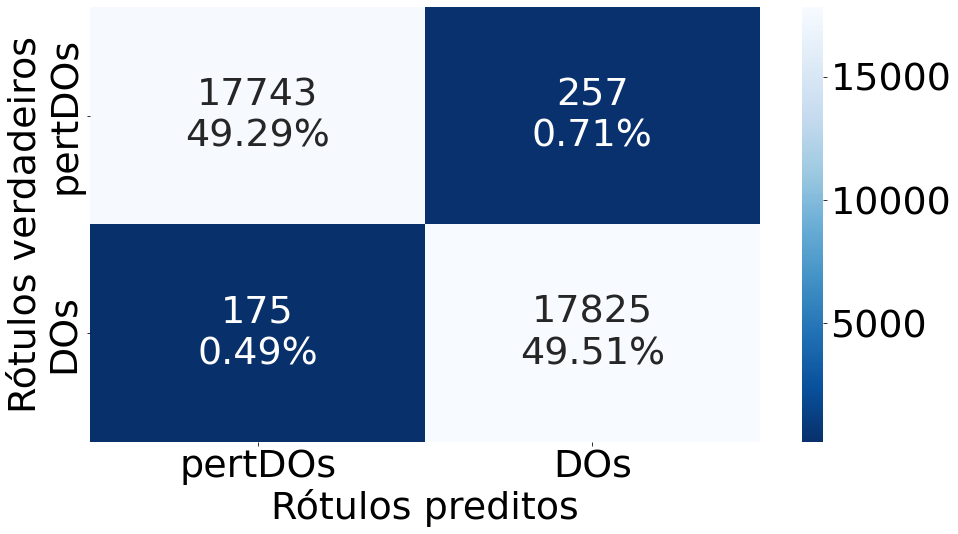

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

X_alvo =     dfDadosClassificacao['classe'].tolist()
y_predicao = dfDadosClassificacao['predicao'].tolist()

print(classification_report(X_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(X_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Rótulos preditos')
# Texto do eixo y
ax.set_ylabel('Rótulos verdadeiros')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['pertDOs','DOs'])
ax.yaxis.set_ticklabels(['pertDOs','DOs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [ ]:
def listaClassificadoCorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    #if i < 20:    
    # 1 - Coerente
    if linha['classe'] == 1 and linha['predicao'] == 1:
        listaRetorno.append(linha['id'])
    # 0 - Incoerente        
    if linha['classe'] == 0 and linha['predicao'] == 0:
        listaRetorno.append(linha['id'])
  
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno

In [ ]:
listaRetornoClassificadoCorretamente = listaClassificadoCorretamente(dfDadosClassificacao)
print('listaRetornoClassificadoCorretamente:', len(listaRetornoClassificadoCorretamente))

listaRetornoClassificadoCorretamente: 35568


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [ ]:
def listaClassificadoIncorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    # 1 - Coerente
    if linha['classe'] == 1 and linha['predicao'] == 0:
        listaRetorno.append(linha['id'])
    # 0 - Incoerente
    if linha['classe'] == 0 and linha['predicao'] == 1:
        listaRetorno.append(linha['id'])
  
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])     
  return dflistaRetorno

In [ ]:
listaRetornoClassificadoIncorretamente = listaClassificadoIncorretamente(dfDadosClassificacao)
print('listaRetornoClassificadoIncorretamente:', len(listaRetornoClassificadoIncorretamente))

listaRetornoClassificadoIncorretamente: 432


#### Acurácia das listas

In [ ]:
total = len(listaRetornoClassificadoCorretamente) + len(listaRetornoClassificadoIncorretamente)
print("Total de documentos:", total)
print("Total de acertos   :", len(listaRetornoClassificadoCorretamente))
print("Total de erros     :", len(listaRetornoClassificadoIncorretamente))
print("Acurácia           :", len(listaRetornoClassificadoCorretamente)/total)

Total de documentos: 36000
Total de acertos   : 35568
Total de erros     : 432
Acurácia           : 0.988


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove as duplicidades dos dados originais.

In [ ]:
print("Com repetição:",len(listaRetornoClassificadoCorretamente))
listaRetornoClassificadoCorretamenteSemRepeticao = listaRetornoClassificadoCorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(listaRetornoClassificadoCorretamenteSemRepeticao))

Com repetição: 35568
Sem repetição: 18643


Remove as duplicidades dos dados perturbados.

In [ ]:
print("Com repetição:",len(listaRetornoClassificadoIncorretamente))
listaRetornoClassificadoIncorretamenteSemRepeticao = listaRetornoClassificadoIncorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(listaRetornoClassificadoIncorretamenteSemRepeticao))

Com repetição: 432
Sem repetição: 319


In [ ]:
print("Documentos originais e perturados e suas classificações:", len(listaRetornoClassificadoCorretamente) + len(listaRetornoClassificadoIncorretamente))
print("  Classificados corretamente(classe=previsão):", len(listaRetornoClassificadoCorretamente))
print("  Classificados incorretamente(classe!=previsão):", len(listaRetornoClassificadoIncorretamente))

DOClasseIncorreta = 0

# Percorre a lista dos documentos originais
for i, linha in lista_documentos_originais.iterrows():
  
  # Limita a quantidade de dados a serem exibidas
  if i < 100:    
  # Procura um documento específico
  #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:
    
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos.loc[lista_documentos_originais_pos["id"] == linha['id']]
    #print("documentos_originais_pos[id]:", documentos_originais_pos["id"].values[0])
    
    # Recupera o id documento original se ele foi classificado corretamente    
    documento_id_original = listaRetornoClassificadoCorretamenteSemRepeticao.loc[listaRetornoClassificadoCorretamenteSemRepeticao["id"] == str(linha['id'])]
    #print("documento_id_original:", documento_id_original)

    # Recupera a classificação do original
    classe = ""
    # Se o documento original foi encontrado foi classificado corretamente
    if len(documento_id_original) != 0:
      #print("documento_id_original:",len(documento_id_original))          
      documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
      #print("documento:",documento)
      classe =  str(documento['classe'].values[0])
    else:
      classe = "0"
      DOClasseIncorreta = DOClasseIncorreta + 1

    # Mostra o documento original e sua classificação
    print("\nDO: " + linha["documento"] + " - " + classe)    
    # POSTagging da sentença
    print("    " + " ".join(documentos_originais_pos["pos_documento"].values[0][0][1]))
    
    # Lista com documentos perturbados e sua classificacao
    lista_perturbado_classificado_correto = []
    lista_perturbado_classificado_incorreto = []

    # Percorre os documentos perturbados e suas classificações a partir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #print("id_perturbado:",id_perturbado)

        # localiza os dados do documento perturbado 
        documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]        
        #print("registro_perturbado_1a_sentenca:", documento_perturbado[3][0][4])
        palavra_mascarada = documento_perturbado[3][0][1]
        token_predito = documento_perturbado[3][0][2]
        peso_predito = documento_perturbado[3][0][3]
        posicao_sorteio = documento_perturbado[3][0][4]

        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = listaRetornoClassificadoCorretamenteSemRepeticao.loc[listaRetornoClassificadoCorretamenteSemRepeticao["id"] == id_perturbado]        
        
        # Se foi encontrado foi classificado corretamente
        if len(documento_id_perturbado_correto) != 0:
          versaoPerturbadaClassificada = True
          #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
          documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == str(documento_id_perturbado_correto['id'].values[0])]
          #print("documento:",documento)
          #saidaPerturbadoCorreto = saidaPerturbadoCorreto + "\n    pert_" + str(j) + ": " + str(documento['documento'].values[0]) + " - " + str(posicao_sorteio) + " - " + str(documento['classe'].values[0])
          lista_perturbado_classificado_correto.append(["pert_" + str(j), str(documento['documento'].values[0]), palavra_mascarada, token_predito, posicao_sorteio, 0 ])

        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = listaRetornoClassificadoIncorretamenteSemRepeticao.loc[listaRetornoClassificadoIncorretamenteSemRepeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado incorretamente
          if len(documento_id_perturbado_incorreto) != 0:
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
            documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == str(documento_id_perturbado_incorreto['id'].values[0])]
            #print("documento:",documento)
            #saidaPerturbadoIncorreto = saidaPerturbadoIncorreto + "\n    pert_" + str(j) + ": " + str(documento['documento'].values[0]) + " - " + str(posicao_sorteio) + " - 1"            
            lista_perturbado_classificado_incorreto.append(["pert_" + str(j), str(documento['documento'].values[0]), palavra_mascarada, token_predito, posicao_sorteio, 1 ])
                
    lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: x[4], reverse=False)
    lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: x[4], reverse=False)

    # Mostra a saída das classificações
    print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))
    if len(lista_perturbado_classificado_correto) != 0:           
      for i, x in enumerate(lista_perturbado_classificado_correto):
          print("  " , x[1]," [" + x[2] + " -> " + x[3] + "(" + str(x[4]) + ")] - ",x[5])
    
    print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))
    if len(lista_perturbado_classificado_incorreto) != 0:           
      for i, x in enumerate(lista_perturbado_classificado_incorreto):
          print("  " ,  x[1]," [" + x[2] + " -> " + x[3] + "(" + str(x[4]) + ")] - ",x[5])

print("\nDocumentos originais classificados incorretamente:", DOClasseIncorreta)

Documentos originais e perturados e suas classificações: 36000
  Classificados corretamente(classe=previsão): 35568
  Classificados incorretamente(classe!=previsão): 432

DO: Como pode ser definido um sistema de informação? - 1
    ADV VERB AUX VERB DET NOUN ADP NOUN PUNCT
  Classificações corretas (classe = predição): 20
   Como devem ser definido um sistema de informação ?  [pode -> devem(21)] -  0
   Como pode ser controlado um sistema de informação ?  [definido -> controlado(25)] -  0
   Como define ser definido um sistema de informação ?  [pode -> define(43)] -  0
   Como pode ser atingido um sistema de informação ?  [definido -> atingido(114)] -  0
   Como geralmente ser definido um sistema de informação ?  [pode -> geralmente(171)] -  0
   Como pode ser adaptado um sistema de informação ?  [definido -> adaptado(190)] -  0
   Como age ser definido um sistema de informação ?  [pode -> age(197)] -  0
   Como ciência ser definido um sistema de informação ?  [pode -> ciência(362)] - 

#### Listas documentos originais e perturbados classificados corretamente

In [ ]:
print("Documentos originais e perturbados classificados corretamente(classe=previsão):", len(listaRetornoClassificadoCorretamente))
conta = 0
for i, linha in listaRetornoClassificadoCorretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados classificados corretamente(classe=previsão): 35568
    1 Qual é o nome dado à máquina que alcançou polinômios por meio de diferenças ? 0
    2 Em quantos segundos o Mark I conseguia multiplicar dois números de dez dígitos? 1
    3 Em quantos segundos o Mark I X multiplicar dois números de dez dígitos ? 0
    4 Quando o curso de Engenharia de Sistemas e Computação da UERJ começou a funcionar? 1
    5 Quando o curso de Engenharia de Sistemas e Computação da UERJ começou a 1978 ? 0
    6 Quando o curso de Engenharia de Sistemas e Computação da UERJ começou a funcionar? 1
    7 Quando o curso de Engenharia de Sistemas e Computação da UERJ iniciando a funcionar ? 0
    8 O que os modelos usados pelos fundamentos científicos da engenharia de software devem permitir ao engenheiro? 1
    9 O que os modelos os pelos fundamentos científicos da engenharia de software devem permitir ao engenheiro ? 0
    10 O que os modelos usados pelos fundamentos científicos da

#### Listas documentos originais e perturbados classificados incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(classe!=previsão):", len(listaRetornoClassificadoIncorretamente))
conta = 0
for i, linha in listaRetornoClassificadoIncorretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados classificados incorretamente(classe!=previsão): 432
    1 Quais disciplinas tem tratamento diferenciado quanto ao processo de verificação de aprendizagem ? 0
    2 Quais os resultados finais que devem ser considerados para trabalho de conclusão de curso ? 0
    3 Estudos realizados no exterior vão ser aproveitados ? 0
    4 A resolução nº 342 torna recorre o quê? 1
    5 A resolução nº 342 torna recorre o quê? 1
    6 A resolução nº 342 torna recorre o quê? 1
    7 O que deve ser anexado no SigProj? 1
    8 O que deve ser anexado no SigProj? 1
    9 O que os professors no Reino Unido geralmente são? 1
    10 O que os professors no Reino Unido geralmente são? 1
    11 O que os professors no Reino Unido geralmente são? 1
    12 Desde quando os processadores vêm sendo construídos em um único circuito integrado? 1
    13 Desde quando os processadores vêm sendo construídos em um único circuito integrado? 1
    14 O que é análise de sistemas? 1
    15 Qual 

### Listas

#### Lista de documentos originais(1-coerente) classificados corretamente(1-coerente)

In [ ]:
def listaOriginalClassificadoCorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        listaRetorno.append(linha['id'])

  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])        
  return dflistaRetorno

In [ ]:
listaDocumentoOriginalClassificadoCorretamente = listaOriginalClassificadoCorretamente(dfDadosClassificacao)
print('listaDocumentoOriginalClassificadoCorretamente:', len(listaDocumentoOriginalClassificadoCorretamente))

listaDocumentoOriginalClassificadoCorretamente: 17825


In [ ]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(listaDocumentoOriginalClassificadoCorretamente))
for i, documento in listaDocumentoOriginalClassificadoCorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

A saída de streaming foi truncada nas últimas 5000 linhas.
   12825 - O que é uma universidade de múltiplos campi? 1
   12826 - O que é uma universidade de múltiplos campi? 1
   12827 - o que os membros do nde devem exercer? 1
   12828 - Como é feito o cálculo do posicionamento do discente no curso? 1
   12829 - Como é feito o cálculo do posicionamento do discente no curso? 1
   12830 - Como é feito o cálculo do posicionamento do discente no curso? 1
   12831 - Como é feito o cálculo do posicionamento do discente no curso? 1
   12832 - Como é feito o cálculo do posicionamento do discente no curso? 1
   12833 - Qual programa do governo oferece bolsas integrais e parciais através da nota do Enem? 1
   12834 - O que evidencia a capacidade de redação de textos científicos do aluno nos trabalhos autônomos? 1
   12835 - Quem é profissional que ministra aulas ou cursos em todos os níveis educacionais no Brasil? 1
   12836 - O coordenador de curso deve elaborar o plano de estudos após a anális

#### Lista de documento originais(1-coerente) classificados incorretamente(0-incoerente)

In [ ]:
def listaOriginalClassificadoIncorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        listaRetorno.append(linha['id'])
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno

In [ ]:
listaDocumentoOriginalClassificadoIncorretamente = listaOriginalClassificadoIncorretamente(dfDadosClassificacao)

print("Lista de documentos originais classificados incorretamente:",len(listaDocumentoOriginalClassificadoIncorretamente))

Lista de documentos originais classificados incorretamente: 175


In [ ]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(listaDocumentoOriginalClassificadoIncorretamente))
for i, documento in listaDocumentoOriginalClassificadoIncorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0): 175
   0 - A resolução nº 342 torna recorre o quê? 1
   1 - A resolução nº 342 torna recorre o quê? 1
   2 - A resolução nº 342 torna recorre o quê? 1
   3 - O que deve ser anexado no SigProj? 1
   4 - O que deve ser anexado no SigProj? 1
   5 - O que os professors no Reino Unido geralmente são? 1
   6 - O que os professors no Reino Unido geralmente são? 1
   7 - O que os professors no Reino Unido geralmente são? 1
   8 - Desde quando os processadores vêm sendo construídos em um único circuito integrado? 1
   9 - Desde quando os processadores vêm sendo construídos em um único circuito integrado? 1
   10 - O que é análise de sistemas? 1
   11 - Quem será responsável por alterar a nota do aluno no Siscad? 1
   12 - Quem será responsável por alterar a nota do aluno no Siscad? 1
   13 - Por quem foi desenvolvido o Pergamum? 1
   14 - Por quem foi desenvolvido o Pergamum? 1
   15 - Quais órgãos c

#### Lista Documentos Perturbados(0-incoerente) Classificados corretamente(0-incoerente)

In [ ]:
def listaPerturbadoClassificadoCorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        listaRetorno.append(linha['id'])
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno

In [ ]:
listaDocumentoPerturbadoClassificadoCorretamente = listaPerturbadoClassificadoCorretamente(dfDadosClassificacao)
print('listaDocumentoPerturbadoClassificadoCorretamente:', len(listaDocumentoPerturbadoClassificadoCorretamente))

listaDocumentoPerturbadoClassificadoCorretamente: 17743


In [ ]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(listaDocumentoPerturbadoClassificadoCorretamente))
for i, documento in listaDocumentoPerturbadoClassificadoCorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

A saída de streaming foi truncada nas últimas 5000 linhas.
   12743 - Do que a aprovação nas disciplinas consideradas ? 0
   12744 - Do que a aprovação nas disciplinas necessária ? 0
   12745 - Do que a aprovação nas disciplinas equivalentes ? 0
   12746 - Estudos realizados no exterior podem ser procedimentos ? 0
   12747 - Qual tema de TCC é elevado ? 0
   12748 - Qual tema de TCC é sempre ? 0
   12749 - Qual tema de TCC é futuro ? 0
   12750 - Quais palavras são pensar como sinônimas pelos autores ? 0
   12751 - Quais palavras são ente como sinônimas pelos autores ? 0
   12752 - Qual a universidade pioneira no brasil em alfabetização de software ? 0
   12753 - Qual a instituições pioneira no brasil em engenharia de software ? 0
   12754 - Qual o decidido do pedido de regime de exercícios domiciliares ? 0
   12755 - Qual o n do pedido de regime de exercícios domiciliares ? 0
   12756 - Qual o mistério do pedido de regime de exercícios domiciliares ? 0
   12757 - Quando uma universida

#### Lista Documentos Perturbados(0-incoerente) Classificados incorretamente(1-coerente)

In [ ]:
def listaPerturbadoClassificadoIncorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        listaRetorno.append(linha['id'])
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno

In [ ]:
listaDocumentoPerturbadoClassificadoIncorretamente = listaPerturbadoClassificadoIncorretamente(dfDadosClassificacao)
print('listaDocumentoPerturbadoClassificadoIncorretamente:', len(listaDocumentoPerturbadoClassificadoIncorretamente))

listaDocumentoPerturbadoClassificadoIncorretamente: 257


In [ ]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(listaDocumentoPerturbadoClassificadoIncorretamente))
for i, documento in listaDocumentoPerturbadoClassificadoIncorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1): 257
   0 - Quais disciplinas tem tratamento diferenciado quanto ao processo de verificação de aprendizagem ? 0
   1 - Quais os resultados finais que devem ser considerados para trabalho de conclusão de curso ? 0
   2 - Estudos realizados no exterior vão ser aproveitados ? 0
   3 - Qual um termo matematicamente equivalente às expressões regulares ? 0
   4 - Onde vai ser feita a matrícula em disciplinas optativas ? 0
   5 - Como são chamadas as instruções no computador ? 0
   6 - Em quais áreas a ciência é uma grande força ? 0
   7 - O que envolve o TCC em cursos voltados à ciências ? 0
   8 - Desde quando o curso de engenharia de computação tem sido associado às universidades ? 0
   9 - Quais os modos de abordagem da pesquisa de campo ? 0
   10 - Qual a formação pioneira no brasil em engenharia de software ? 0
   11 - Qual lei inclui o estágio de estudantes na lei brasileira ? 0
   12 - A mono

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [ ]:
# Nome base das saidas do projeto
NOMEBASESAIDA = "MedidaCoerenciaFaquad_v1"

# Definição dos parâmetros a serem avaliados

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2, 3, 4]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_ssb', '_sve', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  


  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  listaTempoTotal = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:                      
                for estrategia in ESTRATEGIA_MEDIDA:  
                  for filtro_palavra in FILTRO_PALAVRAS:  
                    # Acumuladores.
                    somaAcuracia = 0                    
                    contaReg = 0
                    for i in range(len(arquivos)):                                    
                      if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                          and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                          and (modelo_bert in arquivos[i]) 
                          and (tamanho in arquivos[i]) 
                          and (modelo in arquivos[i]) 
                          and (estrategia in arquivos[i]) 
                          and (filtro_palavra in arquivos[i])):
                             
                        NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                        # Verifica se o arquivo existe.
                        if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                          # Carrega os dados do arquivo  
                          dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                      
                          # Mostra os dados do teste da medida.
                          for index, linha in dados.iterrows():        
                              # Cálculo das estatísticas
                              ccos = (linha['ccos'])
                              cman = (linha['cman'])
                              ceuc = (linha['ceuc'])
                              
                              MELHOR_MEDIDA = -1
                              MELHOR_MEDIDA_STR = ""
                              if ccos >= cman and ccos >= ceuc:
                                  MELHOR_MEDIDA_STR = 'ccos'
                                  MELHOR_MEDIDA = ccos
                              else:
                                  if ceuc >= ccos and ceuc >= cman:
                                      MELHOR_MEDIDA_STR = 'ceuc'
                                      MELHOR_MEDIDA = ceuc
                                  else:
                                      if cman >= ccos and cman >= ceuc:
                                         MELHOR_MEDIDA_STR = 'cman'
                                         MELHOR_MEDIDA = cman
                              
                              if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                MELHOR_TOP_K_PREDICAO = top_k_predicao
                                MELHOR_ESTRATEGIA_MEDIDA = estrategia
                                MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                MELHOR_TEMPO = linha['tempo']
                                MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                MELHOR_MODELO_BERT = modelo_bert
                                MELHOR_TAMANHO_BERT = tamanho
                                MELHOR_MODELO = modelo

                              lista_resultados.append([MELHOR_MODELO_BERT,
                                                       MELHOR_TAMANHO_BERT,
                                                       MELHOR_MODELO,
                                                       documentos_perturbados,
                                                       top_k_predicao, 
                                                       estrategia, 
                                                       filtro_palavra, 
                                                       ccos, 
                                                       ceuc, 
                                                       cman,
                                                       MELHOR_MEDIDA_STR,
                                                       MELHOR_MEDIDA,                                                        
                                                       linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[7], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1, 20]
TOP_K_PREDICAO = [1, 10, 100, 1000]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERTimbau 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 20 
  Top k predição        : 1000 
  Estratégia            : _mean 
  Filtro                : _tap 
  Resultado             : 0.8763333333333333 
  Medida                : ceuc 
  Tempo execução        : 3:27:27

Lista dos resultados ranqueados
1 = ['_BERTimbau', '_large', '_pretreinado', 20, 1000, '_mean', '_tap', 0.3705555555555556, 0.8763333333333333, 0.7445, 'ceuc', 0.8763333333333333, '3:27:27']
2 = ['_BERTimbau', '_large', '_pretreinado', 1, 1000, '_mean', '_tap', 0.3711111111111111, 0.8633333333333333, 0.7488888888888889, 'ceuc', 0.8633333333333333, '0:11:57']
3 = ['_BERTimbau', '_large', '_pretreinado', 1, 1000, '_mean', '_ssw', 0.5411111111111111, 0.8588888888888889, 0.7966666666666666, 'ceuc', 0.8588888888888889, '0:12:03']
4 = ['_BERTimbau', '_large', '_pretreinado', 20, 1000, '_mean', '_ssw',

### Escolhendo um resultado diferente do melhor

In [ ]:
#MELHOR_MODELO_BERT = "_BERTimbau"
#MELHOR_TAMANHO_BERT = "_large"
#MELHOR_MODELO = "_pretreinado"
#MELHOR_DOCUMENTOS_PERTURBADOS = 1
#MELHOR_TOP_K_PREDICAO = 1000
#MELHOR_ESTRATEGIA_MEDIDA = "_max"
#MELHOR_FILTRO_PALAVRAS = "_ssw"
#lista_resultados= []

### 3.1.1 Função que carrega os parâmetros do resultado da melhor mensuração

In [ ]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [ ]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOMEBASESAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + MODELO + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
                     
  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dadosMedida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dadosMedida))

      return dadosMedida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOMEARQUIVOORIGINAL = "original.csv"
NOMEARQUIVOORIGINALCOMPACTADO = "original.zip"
NOMEARQUIVOORIGINALPOS = "originalpos.csv"
NOMEARQUIVOORIGINALPOSCOMPACTADO = "originalpos.zip"

NOMEARQUIVOPERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOMEARQUIVOPERTURBADOCOMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOMEARQUIVOPERTURBADOPOS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOMEARQUIVOPERTURBADOPOSCOMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-03-18 12:51:00,295 : INFO : Diretório já existe: /content/FAQUAD


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOMEARQUIVOORIGINALCOMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOMEARQUIVOORIGINALPOSCOMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOMEARQUIVOPERTURBADOCOMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOMEARQUIVOPERTURBADOPOSCOMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-03-18 12:51:00,849 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOMEARQUIVOORIGINALCOMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOMEARQUIVOORIGINALPOSCOMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOMEARQUIVOPERTURBADOCOMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOMEARQUIVOPERTURBADOPOSCOMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-03-18 12:51:01,393 : INFO : Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOMEARQUIVOORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOMEARQUIVOORIGINALPOS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-03-18 12:51:01,425 : INFO : TERMINADO ORIGINAIS: 900.
2022-03-18 12:51:01,426 : INFO : TERMINADO ORIGINAIS POS: 900.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
122,0211e41566044a14859c928290110cbb,['Por que uma máquina que possui uma fita de t...,Por que uma máquina que possui uma fita de tam...
697,5def773266584a979d37f1dbafae4f0f,['Quais tipos de eventos científicos podem ser...,Quais tipos de eventos científicos podem ser u...
525,a9814c246dee46b59b733c3a473b595e,['O que a máquina de turing utilizava para ope...,O que a máquina de turing utilizava para opera...
91,ee2a6e83216b47f5b390be193221f4e5,['Com quem o computador moderno começou a ganh...,Com quem o computador moderno começou a ganhar...
418,778225ad9bbf4465bc02c22af67402ce,['O que é a monografia segundo o dicionário Au...,O que é a monografia segundo o dicionário Auré...


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
418,778225ad9bbf4465bc02c22af67402ce,"[[['O', 'que', 'é', 'a', 'monografia', 'segund..."
593,fae4ebdaf7aa482b978b7b0b472b141f,"[[['A', 'matrícula', 'em', 'disciplinas', 'iso..."
720,d4e72ad45eee4e64bd9e37a82ecc91b9,"[[['Quem', 'coleta', 'informações', 'sobre', '..."
599,5d670b9c1fa442129c2c4cd6348c4392,"[[['Quais', 'disciplinas', 'possuem', 'tratame..."
165,582872d1a6084badad5bb572535c742c,"[[['Qual', 'era', 'o', 'sonho', 'de', 'Gottfri..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-03-18 12:51:01,538 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 900.
2022-03-18 12:51:01,540 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 900.


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOMEARQUIVOPERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOMEARQUIVOPERTURBADOPOS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-03-18 12:51:01,739 : INFO : TERMINADO PERTURBADOS: 18000.
2022-03-18 12:51:01,741 : INFO : TERMINADO PERTURBADOS POS: 18000.


In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documentoPerturbado,sentencas
3101,77c2e4b820704cd9ad5d07ef366a5994_pert_1,['Como a CPU executado as instruções de um pro...,Como a CPU executado as instruções de um progr...,[['Como a CPU [MASK] as instruções de um progr...
11909,01ca0fcf3d2744a68ea0efb6e97dcee9_pert_9,['Em quais matérias o aluno especial não pode ...,Em quais matérias o aluno especial não pode se...,[['Em quais matérias o aluno especial não pode...
14056,87ea7b87e9464969824a2c692e0b8994_pert_16,['Quando devem ser líquidos os pedidos de apro...,Quando devem ser líquidos os pedidos de aprove...,[['Quando devem ser [MASK] os pedidos de aprov...
7090,24c7b90289b34ed6b47f7f14fa388233_pert_10,['Qual lei compôs a lei da criação da fundação...,Qual lei compôs a lei da criação da fundação ?,[['Qual lei [MASK] a lei da criação da fundaçã...
11268,f0da62e14d584bb69061ceb644c2a906_pert_8,['Qual a duração média de um set ?'],Qual a duração média de um set ?,"[['Qual a duração média de um [MASK] ?', 'dout..."


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
8515,e5fb7004194c4effbe41d3fca32ddff2_pert_15,"[[['Para', 'quem', 'começar', 'a', 'renovação'..."
2746,3b7293145a384882b3fd99feb0310c8f_pert_6,"[[['O', 'que', 'era', 'o', 'banho', 'analítico..."
7422,75e60c95e8c04286adbca511f0660e82_pert_2,"[[['Com', 'quem', 'a', 'Facom', 'possui', 'par..."
11488,4a9d7e7b04f0430b9f82cef937ae6e61_pert_8,"[[['O', 'que', 'os', 'professors', 'no', 'Rein..."
3017,5b5f263d3c1546ddaee84a1a848d2704_pert_17,"[[['O', 'que', 'é', 'crença', '?'], ['PRON', '..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-03-18 12:51:03,563 : INFO : TERMINADO CORREÇÃO PERTURBADO: 18000.
2022-03-18 12:51:03,565 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 18000.


### 3.2.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

lista_documentos_agrupados = []

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
    #print("linha_documento:",linha_documento)
    # Recupera o id do documento
    id_documento = linha_documento[0]     
    #print("id_documento:",id_documento)     
 
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento[1]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
    lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
  
    # Percorre os documentos perturbados apartir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(id_documento) + "_pert_" + str(j)

      # localiza o documento perturbado 
      documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
      # Recupera a sentença do documento perturbado
      lista_perturbado = documento_perturbado[1]
          
      # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
      lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[2], 0])    

logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

Processando 900 documentos originais


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

2022-03-18 12:51:32,060 : INFO : TERMINADO AGRUPAMENTO: 18900.


Converte em um dataframe

In [ ]:
# Cria o dataframe da lista
dflista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

dflista_documentos_agrupados = dflista_documentos_agrupados.astype(tipos)

In [ ]:
dflista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
930,59486cdac8c94e37898e004c62e4047a_pert_5,[O que a metodologia da auto-aprendizagem agra...,O que a metodologia da auto-aprendizagem agrad...,0
11382,e59606c41a424b57992a7da4920dd4b6,[Em qual ano de curso se dá o estágio sanduíche?],Em qual ano de curso se dá o estágio sanduíche?,1
18507,1239bbf8a6b2479390bc55f05e1f2835_pert_5,[o que deverá descobrir o plano de estudos ?],o que deverá descobrir o plano de estudos ?,0
5629,9f9aef06261e43478d3025740ed4cc92_pert_0,[Onde continua um destaque para a engenharia d...,Onde continua um destaque para a engenharia de...,0
15575,1133c29b5e0640b29263e5b1f194c2e9_pert_13,[Pelo que os avanços da informática eram ados ...,Pelo que os avanços da informática eram ados e...,0


In [ ]:
# Importa das bibliotecas
import pandas as pd

# Concatena as listas de documentos originais e perturbados
dflista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(dflista_documentos_agrupados_pos)))

2022-03-18 12:51:32,150 : INFO : TERMINADO AGRUPAMENTO POS: 18900.


In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

dflista_documentos_agrupados_pos = dflista_documentos_agrupados_pos.astype(tipos)

In [ ]:
dflista_documentos_agrupados_pos.sample(5)

,id,pos_documento
14595,5ad7ec48d7b24069bebc0f3848d3b66d_pert_15,"[[[Do, que, a, última, de, decisão, no, setor,..."
354,24c7b90289b34ed6b47f7f14fa388233,"[[[Qual, lei, alterou, a, lei, da, criação, da..."
1227,2c5c585eebcf49e1b6ceb926a85cceef_pert_7,"[[[Por, quem, eram, ificadas, as, tabelas, log..."
2011,1100cf4cf2b54d88bea2eac0e93df77e_pert_11,"[[[Em, que, tem, perdido, os, avanços, recente..."
2344,f6d39f5220f947d4b625afdfa89f1acc_pert_4,"[[[O, que, indicavam, as, áreas, não, furadas,..."


## 3.3 Carregando o resultado da melhor mensuração

In [ ]:
MODELO_BERT = [MELHOR_MODELO_BERT]
TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
MODELO = [MELHOR_MODELO] 
DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

dadosMensuracao = carregaMedidasCompactada(MELHOR_MODELO_BERT, 
                                 MELHOR_TAMANHO_BERT,
                                 MELHOR_MODELO,
                                 MELHOR_DOCUMENTOS_PERTURBADOS, 
                                 MELHOR_TOP_K_PREDICAO,
                                 MELHOR_ESTRATEGIA_MEDIDA,
                                 MELHOR_FILTRO_PALAVRAS)

Registros:  36000


In [ ]:
dadosMensuracao.sample(5)

,data,arquivo,ccos,ceuc,cman
25617,01/03/2022 01:39,cc9cefb6786542a682c0b99f26bd4358_pert_8,0.696407,33.142518,1512.529609
13086,01/03/2022 01:39,ad7f31c0c7c942a4a00c6ab589794583,0.678604,31.889677,1537.063644
14301,01/03/2022 01:39,6066b65076d145658e78b885fcf5496e_pert_10,0.605273,37.284840,1786.564582
1553,01/03/2022 01:39,ecefc6cb3cc44bef8c606567e8ae756b_pert_16,0.722395,30.227405,1424.791667
4229,01/03/2022 01:39,b9d4a99cc94e4df9b52a33db272f6360_pert_14,0.622914,34.384428,1590.341896


### Separa os documentos e remove as repetições

In [ ]:
def separaDocumentos(dadosMedida):
  
  # Separa os originais
  dfOriginalMedida = dadosMedida.loc[dadosMedida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  dfOriginalMedida = dfOriginalMedida.drop_duplicates(subset=['arquivo'])
  print('Registros: ', len(dfOriginalMedida))

  # Separa os perturbados
  dfPerturbadoMedida = dadosMedida.loc[dadosMedida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  dfPerturbadoMedida = dfPerturbadoMedida.drop_duplicates(subset=['arquivo'])
  print('Registros: ', len(dfPerturbadoMedida))

  return dfOriginalMedida, dfPerturbadoMedida  

In [ ]:
dfOriginalMedidaBERT, dfPerturbadoMedidaBERT = separaDocumentos(dadosMensuracao)

Registros:  900
Registros:  18000


### Organiza os pares de documentos

In [ ]:
def organizaParesDocumentos(dfOriginalMedida, dfPerturbadoMedida):

  # Import das bibliotecas.
  import pandas as pd

  listaParesDocumentosMedidas = []
  # Refaz os pares de documentos
  for i, linha1 in dfOriginalMedida.iterrows():
    
    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):
      
      nome_arquivo_perturbado = str(linha1['arquivo']) + "_pert_" + str(j)
      
      docperturbado = dfPerturbadoMedida.loc[dfPerturbadoMedida['arquivo'] == nome_arquivo_perturbado]

      listaParesDocumentosMedidas.append(
                                      [linha1['data'], 
                                       linha1['arquivo'],	
                                       linha1['ccos'], 
                                       linha1['ceuc'], 
                                       linha1['cman'],
                                       
                                       docperturbado['data'].values[0], 
                                       docperturbado['arquivo'].values[0],	
                                       docperturbado['ccos'].values[0], 
                                       docperturbado['ceuc'].values[0], 
                                       docperturbado['cman'].values[0] ],)
      
  print('Registros antes:', len(listaParesDocumentosMedidas))

  dfListaParesDocumentosMedidas = pd.DataFrame(listaParesDocumentosMedidas, columns=('dataDO', 'idDO','ccosDO', 'ceucDO', 'cmanDO', 'dataPert', 'idPert', 'ccosPert', 'ceucPert', 'cmanPert')) 
  
  print('Registros depois:', len(dfListaParesDocumentosMedidas))

  return dfListaParesDocumentosMedidas

In [ ]:
dfListaParesDocumentosMedidasBERT = organizaParesDocumentos(dfOriginalMedidaBERT, dfPerturbadoMedidaBERT)

Registros antes: 18000
Registros depois: 18000


In [ ]:
dfListaParesDocumentosMedidasBERT.sample(5)

,dataDO,idDO,ccosDO,ceucDO,cmanDO,dataPert,idPert,ccosPert,ceucPert,cmanPert
2667,01/03/2022 01:39,1dae3fc8d01144af82a247679e1698e3,0.641070,35.450508,1636.929956,01/03/2022 01:39,1dae3fc8d01144af82a247679e1698e3_pert_7,0.658819,35.735585,1621.729187
17116,01/03/2022 01:39,bb7dc667337b4cf2af309d60a1f1ecb2,0.673822,31.234112,1513.100107,01/03/2022 01:39,bb7dc667337b4cf2af309d60a1f1ecb2_pert_16,0.678064,32.265917,1535.620230
13488,01/03/2022 01:39,6195e07726c44dfdb5db36360e8f6ebd,0.695677,30.159805,1438.167636,01/03/2022 01:39,6195e07726c44dfdb5db36360e8f6ebd_pert_8,0.690028,32.043951,1493.123502
9903,01/03/2022 01:39,3d263b97f9ee48b195790dd190d80224,0.779584,23.836351,1153.175037,01/03/2022 01:39,3d263b97f9ee48b195790dd190d80224_pert_3,0.738437,26.384783,1272.343286
8308,01/03/2022 01:39,a5cafcd0bbbd4c74bb60de2f810db23b,0.707026,30.135051,1450.722400,01/03/2022 01:39,a5cafcd0bbbd4c74bb60de2f810db23b_pert_8,0.679746,31.410085,1512.034985


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
128,33c59ddc361a4288b6594f2152db7b9d,[Como podemos armazenar números maiores na mem...,Como podemos armazenar números maiores na memó...
173,db2a4c7266bf44d6ab07d90227c1312b,[Quais são os componentes da CPU?],Quais são os componentes da CPU?
758,36ae775a973e4b2db6c200e972a98b83,[Para que cada profissional tem um papel nas o...,Para que cada profissional tem um papel nas or...
615,f3a38e6e0cb6480bac4b6661a9558acc,[Quando o acadêmico em regime de exercícios do...,Quando o acadêmico em regime de exercícios dom...
210,63a1241f10134c59a6f7d6f70f6e043a,[Quantas instruções dos programas de computado...,Quantas instruções dos programas de computador...


## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [ ]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(dfListaParesDocumentosMedidas, medida):
  listaRetorno = []  
  for i, linha in dfListaParesDocumentosMedidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + 'DO'] <= linha[ medida + 'Pert']:
        listaRetorno.append(linha['idDO'])        
        listaRetorno.append(linha['idPert'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + 'DO'] <= linha[ medida + 'Pert']:
          listaRetorno.append(linha['idDO'])          
          listaRetorno.append(linha['idPert'])

  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno  

In [ ]:
listaRetornoMedidoCorretamente = listaMedidaCorretamente(dfListaParesDocumentosMedidasBERT,"ccos")
print('listaRetornoMedidoCorretamente:', len(listaRetornoMedidoCorretamente))

listaRetornoMedidoCorretamente: 13340


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [ ]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(dfListaParesDocumentosMedidas, medida):
  listaRetorno = []  
  for i, linha in dfListaParesDocumentosMedidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + 'DO'] < linha[ medida + 'Pert']:
        listaRetorno.append(linha['idDO'])        
        listaRetorno.append(linha['idPert'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + 'DO'] > linha[ medida + 'Pert']:
          listaRetorno.append(linha['idDO'])          
          listaRetorno.append(linha['idPert'])


  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno  

In [ ]:
listaRetornoMedidoIncorretamente = listaMedidaIncorretamente(dfListaParesDocumentosMedidasBERT,'ccos')
print('listaRetornoMedidoIncorretamente:', len(listaRetornoMedidoIncorretamente))

listaRetornoMedidoIncorretamente: 22660


#### Acertos das listas

In [ ]:
total = len(listaRetornoMedidoCorretamente) + len(listaRetornoMedidoIncorretamente)
print("Total de documentos:", total)
print("Total de acertos   :", len(listaRetornoMedidoCorretamente))
print("Total de erros     :", len(listaRetornoMedidoIncorretamente))
print("Percentual acerto  :", len(listaRetornoMedidoCorretamente)/total)

Total de documentos: 36000
Total de acertos   : 13340
Total de erros     : 22660
Percentual acerto  : 0.3705555555555556


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [ ]:
print("Com repetição:",len(listaRetornoMedidoCorretamente))
listaRetornoMedidoCorretamenteSemRepeticao = listaRetornoMedidoCorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(listaRetornoMedidoCorretamente))

Com repetição: 13340
Sem repetição: 13340


Remove as duplicidades dos dados perturbados.

In [ ]:
print("Com repetição:",len(listaRetornoMedidoIncorretamente))
listaRetornoMedidoIncorretamenteSemRepeticao = listaRetornoMedidoIncorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(listaRetornoMedidoIncorretamenteSemRepeticao))

Com repetição: 22660
Sem repetição: 12178


#### Listas documentos originais e perturbados medidos corretamente

In [ ]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(listaRetornoMedidoCorretamente))
conta = 0
for i, linha in listaRetornoMedidoCorretamente.iterrows():
  conta = conta + 1
  if i < 100:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 13340
    1 Como pode ser definido um sistema de informação? 1
    2 Como ciência ser definido um sistema de informação ? 0
    3 Como pode ser definido um sistema de informação? 1
    4 Como expressa ser definido um sistema de informação ? 0
    5 Como pode ser definido um sistema de informação? 1
    6 Como significado ser definido um sistema de informação ? 0
    7 Como pode ser definido um sistema de informação? 1
    8 Como age ser definido um sistema de informação ? 0
    9 Como pode ser definido um sistema de informação? 1
    10 Como devem ser definido um sistema de informação ? 0
    11 Como pode ser definido um sistema de informação? 1
    12 Como rede ser definido um sistema de informação ? 0
    13 Como pode ser definido um sistema de informação? 1
    14 Como essencial ser definido um sistema de informação ? 0
    15 Como pode ser definido um sistema de informação? 1
    16 Como evoluiu ser de

#### Listas documentos originais e perturbados medidos incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(listaRetornoMedidoIncorretamente))
conta = 0
for i, linha in listaRetornoMedidoIncorretamente.iterrows():
  conta = conta + 1
  if i < 100:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 22660
    1 Como pode ser definido um sistema de informação? 1
    2 Como iria ser definido um sistema de informação ? 0
    3 Como pode ser definido um sistema de informação? 1
    4 Como pode ser parte um sistema de informação ? 0
    5 Como pode ser definido um sistema de informação? 1
    6 Como pode ser futuro um sistema de informação ? 0
    7 Como pode ser definido um sistema de informação? 1
    8 Como pode ser essa um sistema de informação ? 0
    9 Como pode ser definido um sistema de informação? 1
    10 Como pode ser emprestado um sistema de informação ? 0
    11 Como pode ser definido um sistema de informação? 1
    12 Como pode ser coberto um sistema de informação ? 0
    13 Como pode ser definido um sistema de informação? 1
    14 Como pode ser controlado um sistema de informação ? 0
    15 Como pode ser definido um sistema de informação? 1
    16 Como pode ser adaptado um sistema de 

### Listas

#### Lista de documentos originais(1-coerente) medidos corretamente(1-coerente)

In [ ]:
def listaOriginalMedidoCorretamente(dfListaParesDocumentosMedidas, medida):
  listaRetorno = []  
  for i, linha in dfListaParesDocumentosMedidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + 'DO'] <= linha[ medida + 'Pert']:
        listaRetorno.append(linha['idDO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + 'DO'] <= linha[ medida + 'Pert']:
          listaRetorno.append(linha['idDO'])
          
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno  

In [ ]:
listaDocumentoOriginalMedidoCorretamente = listaOriginalMedidoCorretamente(dfListaParesDocumentosMedidasBERT, MELHOR_MEDIDA_GERAL_STR)
print('listaDocumentoOriginalMedidoCorretamente:', len(listaDocumentoOriginalMedidoCorretamente))

listaDocumentoOriginalMedidoCorretamente: 15774


In [ ]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(listaDocumentoOriginalMedidoCorretamente))
for i, documento in listaDocumentoOriginalMedidoCorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

A saída de streaming foi truncada nas últimas 5000 linhas.
   10774 - Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham cumprido todos os pré-requisitos? 1
   10775 - Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham cumprido todos os pré-requisitos? 1
   10776 - Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham cumprido todos os pré-requisitos? 1
   10777 - Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham cumprido todos os pré-requisitos? 1
   10778 - Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham cumprido todos os pré-requisitos? 1
   10779 - O que deve ser respeitado na inscrição das disciplinas? 1
   10780 - O que deve ser respeitado na inscrição das disciplinas? 1
   10781 - O que deve ser respeitado na inscrição das disciplinas? 1
   10782 - O que de

#### Lista de documento originais(1-coerente) medidos incorretamente(0-incoerente)

In [ ]:
def listaOriginalMedidoIncorretamente(dfListaParesDocumentosMedidas, medida):
  listaRetorno = []  
  for i, linha in dfListaParesDocumentosMedidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + 'DO'] > linha[ medida + 'Pert']:
        listaRetorno.append(linha['idDO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + 'DO'] > linha[ medida + 'Pert']:
          listaRetorno.append(linha['idDO'])
          
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno  

In [ ]:
listaDocumentoOriginalMedidoIncorretamente = listaOriginalMedidoIncorretamente(dfListaParesDocumentosMedidasBERT, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(listaDocumentoOriginalMedidoIncorretamente))

Lista de documentos originais medidos incorretamente: 2226


In [ ]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) < CSm(pertDO)):", len(listaDocumentoOriginalMedidoIncorretamente))
for i, documento in listaDocumentoOriginalMedidoIncorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) < CSm(pertDO)): 2226
   0 - Como pode ser definido um sistema de informação? 1
   1 - Como pode ser definido um sistema de informação? 1
   2 - Por que a preocupação com a coleta, armazenamento, processamento e transmissão da informação cresce? 1
   3 - Por que a preocupação com a coleta, armazenamento, processamento e transmissão da informação cresce? 1
   4 - Por que a preocupação com a coleta, armazenamento, processamento e transmissão da informação cresce? 1
   5 - Por que a preocupação com a coleta, armazenamento, processamento e transmissão da informação cresce? 1
   6 - Por que a preocupação com a coleta, armazenamento, processamento e transmissão da informação cresce? 1
   7 - Por que a preocupação com a coleta, armazenamento, processamento e transmissão da informação cresce? 1
   8 - Por que a preocupação com a coleta, armazenamento, processamento e transmissão da informação cresce? 1
   9 - Por que a pr

#### Lista Documentos Perturbados(0-incoerente) medidos corretamente(0-incoerente)

In [ ]:
def listaPerturbadoMedidosCorretamente(dfListaParesDocumentosMedidas, medida):
  listaRetorno = []  
  for i, linha in dfListaParesDocumentosMedidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + 'DO'] <= linha[ medida + 'Pert']:
         listaRetorno.append(linha['idPert'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + 'DO'] <= linha[ medida + 'Pert']:
           listaRetorno.append(linha['idPert'])
          
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno    

In [ ]:
listaDocumentoPerturbadoMedidoCorretamente  = listaPerturbadoMedidosCorretamente(dfListaParesDocumentosMedidasBERT, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(listaDocumentoPerturbadoMedidoCorretamente ))

Lista de documentos perturbados medidos corretamente: 15774


In [ ]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(listaDocumentoPerturbadoMedidoCorretamente ))
for i, documento in listaDocumentoPerturbadoMedidoCorretamente .iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

A saída de streaming foi truncada nas últimas 5000 linhas.
   10774 - Em qual ano os alunos de colação de grau P ser matriculados em disciplinas sem que tenham cumprido todos os pré-requisitos ? 0
   10775 - Em qual ano os alunos de colação de grau poderão ser frequ em disciplinas sem que tenham cumprido todos os pré-requisitos ? 0
   10776 - Em qual ano os alunos de colação de grau poderão ser Campeões em disciplinas sem que tenham cumprido todos os pré-requisitos ? 0
   10777 - Em qual ano os alunos de colação de grau poderão ser livros em disciplinas sem que tenham cumprido todos os pré-requisitos ? 0
   10778 - Em qual ano os alunos de colação de grau poderão ser suficientes em disciplinas sem que tenham cumprido todos os pré-requisitos ? 0
   10779 - O que importância ser respeitado na inscrição das disciplinas ? 0
   10780 - O que deve ser lar na inscrição das disciplinas ? 0
   10781 - O que deve ser alvo na inscrição das disciplinas ? 0
   10782 - O que deve ser Carta na inscri

#### Lista Documentos Perturbados(0-incoerente) medidos  incorretamente(1-coerente)

In [ ]:
def listaPerturbadoMedidosIncorretamente(dfListaParesDocumentosMedidas, medida):
  listaRetorno = []  
  for i, linha in dfListaParesDocumentosMedidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + 'DO'] > linha[ medida + 'Pert']:
         listaRetorno.append(linha['idPert'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + 'DO'] > linha[ medida + 'Pert']:
           listaRetorno.append(linha['idPert'])
          
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno    

In [ ]:
listaDocumentoPerturbadoMedidoIncorretamente = listaPerturbadoMedidosIncorretamente(dfListaParesDocumentosMedidasBERT,MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(listaDocumentoPerturbadoMedidoIncorretamente))

Lista de documentos perturbados medidos incorretamente: 2226


In [ ]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(listaDocumentoPerturbadoMedidoIncorretamente))
for i, documento in listaDocumentoPerturbadoMedidoIncorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 2226
   0 - Como iria ser definido um sistema de informação ? 0
   1 - Como pode ser controlado um sistema de informação ? 0
   2 - Por que a preocupação com a coleta , armazenamento , processamento e transmissão da informação chegou ? 0
   3 - Por que a preocupação com a coleta , armazenamento , processamento e transmissão da informação travada ? 0
   4 - Por que a preocupação com a coleta , armazenamento , processamento e transmissão da informação aliada ? 0
   5 - Por que a preocupação com a coleta , armazenamento , processamento e transmissão da informação pesquisa ? 0
   6 - Por que a preocupação com a coleta , armazenamento , processamento e transmissão da informação iniciada ? 0
   7 - Por que a preocupação com a coleta , armazenamento , processamento e transmissão da informação perigosa ? 0
   8 - Por que a preocupação com a coleta , armazenamento , processamento e transmissão da informaçã

# 5 Compara os resultados

Listas das classificações
* listaDocumentoOriginalClassificadoCorretamente
* listaDocumentoOriginalClassificadoIncorretamente
* listaDocumentoPerturbadoClassificadoCorretamente
* listaDocumentoPerturbadoClassificadoIncorretamente


Lista das medições
* listaDocumentoOriginalMedidoCorretamente 12
* listaDocumentoOriginalMedidoIncorretamente 8
* listaDocumentoPerturbadoMedidoCorretamente 12
* listaDocumentoPerturbadoMedidoIncorretamente 8

In [ ]:
total_classificacao = (len(listaDocumentoOriginalClassificadoCorretamente) + 
                       len(listaDocumentoOriginalClassificadoIncorretamente) + 
                       len(listaDocumentoPerturbadoClassificadoCorretamente) + 
                       len(listaDocumentoPerturbadoClassificadoIncorretamente))
print("total_classificacao:", total_classificacao)

print("DO classificados corretamente:", 
      len(listaDocumentoOriginalClassificadoCorretamente), 
      " / {0:.2%} do total".format(len(listaDocumentoOriginalClassificadoCorretamente)/total_classificacao))
print("DO classificados incorretamente:", 
      len(listaDocumentoOriginalClassificadoIncorretamente), 
      " / {0:.2%} do total".format(len(listaDocumentoOriginalClassificadoIncorretamente)/total_classificacao))
print("pertDO classificados corretamente:", 
      len(listaDocumentoPerturbadoClassificadoCorretamente), 
      " / {0:.2%} do total".format(len(listaDocumentoPerturbadoClassificadoCorretamente)/total_classificacao))
print("pertDO classificados incorretamente:", 
      len(listaDocumentoPerturbadoClassificadoIncorretamente), 
      " / {0:.2%} do total".format(len(listaDocumentoPerturbadoClassificadoIncorretamente)/total_classificacao))

total_medicao = (len(listaDocumentoOriginalMedidoCorretamente) +
                 len(listaDocumentoOriginalMedidoIncorretamente) + 
                 len(listaDocumentoPerturbadoMedidoCorretamente) + 
                 len(listaDocumentoPerturbadoMedidoIncorretamente))

print()
print("total_medicao:",total_medicao)

print("DO medidos corretamente:", 
      len(listaDocumentoOriginalMedidoCorretamente), 
      " / {0:.2%} do total".format(len(listaDocumentoOriginalMedidoCorretamente)/total_medicao))
print("DO medidos incorretamente:", 
      len(listaDocumentoOriginalMedidoIncorretamente), 
      " / {0:.2%} do total".format(len(listaDocumentoOriginalMedidoIncorretamente)/total_medicao))
print("pertDO medidos corretamente:", 
      len(listaDocumentoPerturbadoMedidoCorretamente), 
      " / {0:.2%} do total".format(len(listaDocumentoPerturbadoMedidoCorretamente)/total_medicao))
print("pertDO medidos incorretamente:", 
      len(listaDocumentoPerturbadoMedidoIncorretamente), 
      " / {0:.2%} do total".format(len(listaDocumentoPerturbadoMedidoIncorretamente)/total_medicao))

total_classificacao: 36000
DO classificados corretamente: 17825  / 49.51% do total
DO classificados incorretamente: 175  / 0.49% do total
pertDO classificados corretamente: 17743  / 49.29% do total
pertDO classificados incorretamente: 257  / 0.71% do total

total_medicao: 36000
DO medidos corretamente: 15774  / 43.82% do total
DO medidos incorretamente: 2226  / 6.18% do total
pertDO medidos corretamente: 15774  / 43.82% do total
pertDO medidos incorretamente: 2226  / 6.18% do total


## Documentos originais classificados e medidos corretamente

In [ ]:
listaIntersecao = []
for i, documento1 in listaDocumentoOriginalClassificadoCorretamente.iterrows():
  procura = documento1["id"]
  documento2 = listaDocumentoOriginalMedidoCorretamente.loc[listaDocumentoOriginalMedidoCorretamente["id"] == procura]
  if len(documento2) != 0:        
      listaIntersecao.append(documento1["id"])

In [ ]:
if len(listaIntersecao) != 0:    
  percentual = len(listaIntersecao)/total_classificacao
  print ("Lista de documentos originais que foram classificados e medidos corretamente: ", len(listaIntersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(listaIntersecao):
    if i < 100:
      print(x)
else:
  print("Não existe documentos originais que foram classificados e medidos corretamente ")

Lista de documentos originais que foram classificados e medidos corretamente:  17729  / 49.25% do total
bbca4bfb0a98484e87709baa4b0105be
4b0569a40aa24c4d9e842d78a922b832
4b0569a40aa24c4d9e842d78a922b832
d35a68e1e8344f38aee681eb5ba72c77
d35a68e1e8344f38aee681eb5ba72c77
2f8b4896dd3d4692a4e286fb40826df5
2f8b4896dd3d4692a4e286fb40826df5
b4bf6ca3ed294ec6ad5410f1071031a9
afb217fec90c418f9df75a46eb329f78
afb217fec90c418f9df75a46eb329f78
98355d419f664393ad000940492a80a3
a522ca722b5046c498e41d97b36fe029
a522ca722b5046c498e41d97b36fe029
13c20d4e1a8a4ae9a556e6986524cefa
13c20d4e1a8a4ae9a556e6986524cefa
939e08851c6c469da76d0c58d47e225c
939e08851c6c469da76d0c58d47e225c
e751f65638fc4f70acbea26a49ad5992
e751f65638fc4f70acbea26a49ad5992
e751f65638fc4f70acbea26a49ad5992
e751f65638fc4f70acbea26a49ad5992
e751f65638fc4f70acbea26a49ad5992
b40be90835fa413fa7c65547c4bfdf3d
5d670b9c1fa442129c2c4cd6348c4392
5d670b9c1fa442129c2c4cd6348c4392
5d670b9c1fa442129c2c4cd6348c4392
5d670b9c1fa442129c2c4cd6348c4392
cb9a0

## Documentos originais classificados e medidos incorretamente

In [ ]:
listaIntersecao = []
for i, documento1 in listaDocumentoOriginalClassificadoIncorretamente.iterrows():
  procura = documento1["id"]
  documento2 = listaDocumentoOriginalMedidoIncorretamente.loc[listaDocumentoOriginalMedidoIncorretamente["id"] == procura]
  if len(documento2) != 0:        
      listaIntersecao.append(documento1["id"])

In [ ]:
if len(listaIntersecao) != 0:    
  percentual = len(listaIntersecao)/total_classificacao
  print ("Lista de documentos originais que foram classificados e medidos incorretamente: ", len(listaIntersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(listaIntersecao):
    if i < 100:
      print(x)
else:
  print("Não existe documentos originais que foram classificados e medidos incorretamente ")

Lista de documentos originais que foram classificados e medidos incorretamente:  95  / 0.26% do total
10b4f7a2173242bea85ffe5781439384
10b4f7a2173242bea85ffe5781439384
10b4f7a2173242bea85ffe5781439384
3f8ee2355e1f4745a10f55a9cc41396f
71dbbf324d054924a3c503480486bb74
71dbbf324d054924a3c503480486bb74
483b327d3f80408fa56ffa3e3778aabf
68e685786c0745cf9d4529e10c79f316
68e685786c0745cf9d4529e10c79f316
0d9152126eb14923a0110320e0868290
0d9152126eb14923a0110320e0868290
c62511babcc444ae9f76d9c672ab30a7
c62511babcc444ae9f76d9c672ab30a7
b11d5b1f4a1c4f69b982320656943681
b11d5b1f4a1c4f69b982320656943681
39c4c128a2cf4a3ea948786c5388902f
39c4c128a2cf4a3ea948786c5388902f
39c4c128a2cf4a3ea948786c5388902f
39c4c128a2cf4a3ea948786c5388902f
1d746320923348268c07ffb59dff6a5f
1d746320923348268c07ffb59dff6a5f
1d746320923348268c07ffb59dff6a5f
b74772acc3f149498a35481c365dbf97
b74772acc3f149498a35481c365dbf97
0f2f727416a14b6d8abab36816e04f9f
e8413a5836124c9f85fbeec8ac228621
e8413a5836124c9f85fbeec8ac228621
e8413a5

## Documentos perturbados classificados e medidos corretamente

In [ ]:
listaIntersecao = []
for i, documento1 in listaDocumentoPerturbadoClassificadoCorretamente.iterrows():
  procura = documento1["id"]
  documento2 = listaDocumentoPerturbadoMedidoCorretamente.loc[listaDocumentoPerturbadoMedidoCorretamente["id"] == procura]
  if len(documento2) != 0:        
      listaIntersecao.append(documento1["id"])

In [ ]:
if len(listaIntersecao) != 0:    
  percentual = len(listaIntersecao)/total_classificacao
  print ("Lista de documentos perturbados que foram classificados e medidos corretamente: ", len(listaIntersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(listaIntersecao):
    if i < 100:
      print(x)
else:
  print("Não existe documentos perturbados que foram classificados e medidos corretamente ")

Lista de documentos perturbados que foram classificados e medidos corretamente:  15610  / 43.36% do total
32ff57978a214146b797eeea9214df41_pert_15
4b0569a40aa24c4d9e842d78a922b832_pert_10
4b0569a40aa24c4d9e842d78a922b832_pert_14
d35a68e1e8344f38aee681eb5ba72c77_pert_9
d35a68e1e8344f38aee681eb5ba72c77_pert_15
920b6cce13e14bf1b93469532a7051cf_pert_18
2f8b4896dd3d4692a4e286fb40826df5_pert_9
b4bf6ca3ed294ec6ad5410f1071031a9_pert_16
afb217fec90c418f9df75a46eb329f78_pert_13
afb217fec90c418f9df75a46eb329f78_pert_18
a522ca722b5046c498e41d97b36fe029_pert_7
a522ca722b5046c498e41d97b36fe029_pert_19
13c20d4e1a8a4ae9a556e6986524cefa_pert_7
e98e9e52a66c420ba22910c17265c229_pert_0
42f1e4ed6b614b149ab18de686215571_pert_0
42f1e4ed6b614b149ab18de686215571_pert_5
939e08851c6c469da76d0c58d47e225c_pert_6
939e08851c6c469da76d0c58d47e225c_pert_11
e751f65638fc4f70acbea26a49ad5992_pert_7
e751f65638fc4f70acbea26a49ad5992_pert_13
e751f65638fc4f70acbea26a49ad5992_pert_15
e751f65638fc4f70acbea26a49ad5992_pert_18
e

## Documentos perturbados classificados e medidos incorretamente

In [ ]:
listaIntersecao = []
for i, documento1 in listaDocumentoPerturbadoClassificadoIncorretamente.iterrows():
  procura = documento1["id"]
  documento2 = listaDocumentoPerturbadoMedidoIncorretamente.loc[listaDocumentoPerturbadoMedidoIncorretamente["id"] == procura]
  if len(documento2) != 0:        
      listaIntersecao.append(documento1["id"])

In [ ]:
if len(listaIntersecao) != 0:    
  percentual = len(listaIntersecao)/total_classificacao
  print ("Lista de documentos perturbados que foram classificados e medidos incorretamente: ", len(listaIntersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(listaIntersecao):
    if i < 20:
      print(x)
else:
  print("Não existe documentos perturbados que foram classificados e medidos incorretamente ")

Lista de documentos perturbados que foram classificados e medidos incorretamente:  93  / 0.26% do total
cb9a0ac3fafd4772b5735300a0e1223a_pert_4
d67dd5989ed6424195a43beeaf28488a_pert_3
1a36740cd52d416a9472e7a56a2a80f2_pert_4
4a9655eba0094bab94312408ba385223_pert_18
11bb37f4a9d340fbbadffe26feb6aad1_pert_0
97cd8d9df5c746228be10421176b486a_pert_6
76213c50ab0b47c7b465562ae17ba98c_pert_3
e8504b304dfc47a096167d0f13f52774_pert_14
e88ce7b72b864607a3ba7f55a782dcbd_pert_15
0c8d7a0093b6433d838a427425788606_pert_19
db2a4c7266bf44d6ab07d90227c1312b_pert_14
e8504b304dfc47a096167d0f13f52774_pert_17
bc649c8e94fd489b96bc6274af04ca6c_pert_2
7e00d87ee5c5462686e4c5ce506a673f_pert_14
879f1d34d55b42fb9a0250288ca2537e_pert_15
4c40f79958644cf598797fa5da085ec6_pert_3
806c7408b59a424e8e086c3cb83ae9eb_pert_18
4a9655eba0094bab94312408ba385223_pert_17
06759927776b4321889dbeb37b29582c_pert_10
e91c36b57c7b4cfbb156d31e5f00a845_pert_10


# 6 Finalização

## 6.3 Tempo final de processamento

Tempo processamento:  1:34:52 (h:mm:ss)

In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
finalProcessamento = time.time()
tempoTotalProcessamento = formataTempo(finalProcessamento - inicioProcessamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempoTotalProcessamento))


  Tempo processamento:  0:10:13 (h:mm:ss)
